In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import streamlit as st
from PIL import Image
import random
import langchain
from langchain.llms import OpenAI


In [5]:
dataset_path = "Brain_tumor_dataset"
categories = ["glioma", "meningioma", "pituitary", "no_tumor"]

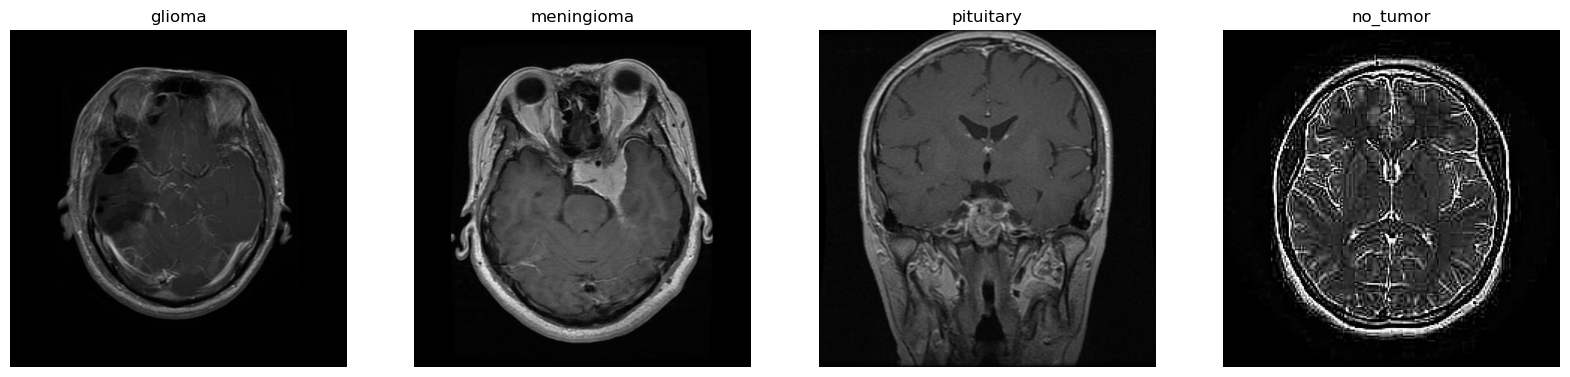

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Adjusted the grid size to 1 row and 4 columns

for i, category in enumerate(categories):
    try:
        category_path = os.path.join(dataset_path, "training", category)
        img_name = random.choice(os.listdir(category_path))
        img_path = os.path.join(category_path, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax = axes[i]  # Directly indexing since it's a 1x4 grid
        ax.imshow(img)
        ax.set_title(category)
        ax.axis("off")
    except Exception as e:
        print(f"Error loading image from {category}: {e}")

plt.show()

In [15]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    rotation_range=10,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1
)
test_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory(
    os.path.join(dataset_path, "training"),
    target_size=(224, 224),
    batch_size=128,
    class_mode="categorical"
)
val = test_datagen.flow_from_directory(
    os.path.join(dataset_path, "testing"),
    target_size=(224, 224),
    batch_size=128,
    class_mode="categorical"
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [16]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Assuming train.labels contains the labels for your training dataset
train_labels = train.labels  # Replace with your actual label array

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to dictionary format (required by some frameworks)
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weight_dict)


Class Weights: {0: 1.080999242997729, 1: 1.0664675130694548, 2: 0.8952978056426333, 3: 0.9800960878517502}


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout

# Define the optimized CNN model
model = Sequential()

# First convolutional block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# Second convolutional block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# Third convolutional block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# Fourth convolutional block
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# Fifth convolutional block (added for deeper feature extraction)
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# Replace Flatten with Global Average Pooling for better Grad-CAM compatibility
model.add(GlobalAveragePooling2D())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))  # Reduced dropout rate for better regularization
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Output layer for multi-class classification (4 classes)
model.add(Dense(4, activation='softmax'))

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Display the model summary to verify the architecture
model.summary()


c:\Users\Purnendu Kale\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 10, 10, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             

 Total params: 1,999,940 (7.63 MB)

 Trainable params: 1,997,956 (7.62 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [18]:
history = model.fit(
    train, 
    epochs=25,  # Adjust the number of epochs based on your needs
    validation_data=val, 
    class_weight=class_weight_dict,  # Use class weights during training
    batch_size=128  # Batch size (you can adjust as necessary)
)

c:\Users\Purnendu Kale\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 480s 10s/step - accuracy: 0.5273 - loss: 1.1609 - val_accuracy: 0.2288 - val_loss: 2.4602
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 378s 8s/step - accuracy: 0.7420 - loss: 0.6807 - val_accuracy: 0.2288 - val_loss: 4.2616
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1469s 8s/step - accuracy: 0.7977 - loss: 0.5554 - val_accuracy: 0.2296 - val_loss: 6.2297
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 385s 8s/step - accuracy: 0.8447 - loss: 0.4517 - val_accuracy: 0.2685 - val_loss: 4.8839
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 381s 8s/step - accuracy: 0.8530 - loss: 0.4058 - val_accuracy: 0.2288 - val_loss: 8.6446
Epoch 6/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 380s 8s/step - accuracy: 0.8673 - loss: 0.3833 - val_accuracy: 0.2311 - val_loss: 8.2751
Epoch 7/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 327s 7s/step - accuracy: 0.8744 - loss: 0.3625 - val_accuracy: 0.2563 - val_loss: 4.8239
Epoch 8/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 328s 7s/step - accuracy: 0.8948 - loss: 0.3167 - val_accuracy: 0.4615 -

In [19]:
model.save("classification_model.h5")
